<a href="https://colab.research.google.com/github/Trassop/Satellite_Classification/blob/main/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How does choice of activation function affect the performance of a neural network?

In [44]:
#@title Data Processing

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess data
satellite_data = pd.read_csv('Satellite_Data.csv')
columns_of_interest = ["Class of Orbit", "Type of Orbit", "Perigee (Kilometers)",
                       "Apogee (Kilometers)", "Inclination (Degrees)"]
processed_data = satellite_data[columns_of_interest].copy()

processed_data["Class of Orbit"] = processed_data["Class of Orbit"].fillna("Unknown")
processed_data["Type of Orbit"] = processed_data["Type of Orbit"].fillna("Unknown")
processed_data["Perigee (Kilometers)"] = processed_data["Perigee (Kilometers)"].fillna(
    processed_data["Perigee (Kilometers)"].mean())
processed_data["Apogee (Kilometers)"] = processed_data["Apogee (Kilometers)"].fillna(
    processed_data["Apogee (Kilometers)"].mean())
processed_data["Inclination (Degrees)"] = processed_data["Inclination (Degrees)"].fillna(0)

processed_data["Altitude (Kilometers)"] = processed_data.apply(
    lambda row: row["Perigee (Kilometers)"] if row["Apogee (Kilometers)"] == 0 else
                row["Apogee (Kilometers)"] if row["Perigee (Kilometers)"] == 0 else
                (row["Perigee (Kilometers)"] + row["Apogee (Kilometers)"]) / 2, axis=1)

# Features and targets
X = processed_data[["Altitude (Kilometers)", "Inclination (Degrees)"]]
y_class = LabelEncoder().fit_transform(processed_data["Class of Orbit"])
y_type = LabelEncoder().fit_transform(processed_data["Type of Orbit"])

# Combine `y_class` and `y_type` into a single 1D array
combined_targets = y_class * len(np.unique(y_type)) + y_type

# Split into training/validation/test sets
X_train, X_test, y_train_combined, y_test_combined = train_test_split(
    X, combined_targets, test_size=0.2, random_state=42)

# Decode the combined targets back into `y_class` and `y_type`
y_train_class = y_train_combined // len(np.unique(y_type))
y_train_type = y_train_combined % len(np.unique(y_type))
y_test_class = y_test_combined // len(np.unique(y_type))
y_test_type = y_test_combined % len(np.unique(y_type))

# Further split training data into training and validation sets
X_train, X_val, y_train_class, y_val_class, y_train_type, y_val_type = train_test_split(
    X_train, y_train_class, y_train_type, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_class_tensor = torch.tensor(y_train_class, dtype=torch.long)
y_train_type_tensor = torch.tensor(y_train_type, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_class_tensor = torch.tensor(y_val_class, dtype=torch.long)
y_val_type_tensor = torch.tensor(y_val_type, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_class_tensor = torch.tensor(y_test_class, dtype=torch.long)
y_test_type_tensor = torch.tensor(y_test_type, dtype=torch.long)

The Neural Network from from Q2 has been adjusted to allow the activation function to be changed from relu. This is done with an "activation" variable that assigned an activation function based on the options provided within Torch.

In [45]:
# Define the neural network with configurable activation
class MultiOutputNeuralNetwork(nn.Module):
    def __init__(self, input_dim, class_output_dim, type_output_dim, activation='relu'):
        super(MultiOutputNeuralNetwork, self).__init__()
        self.shared_fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.shared_fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.class_output = nn.Linear(32, class_output_dim)
        self.type_output = nn.Linear(32, type_output_dim)
        self.softmax = nn.Softmax(dim=1)

        # Map activation function
        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU(0.01),
            'elu': nn.ELU(),
        }
        if activation not in activations:
            raise ValueError(f"Unsupported activation: {activation}")
        self.activation = activations[activation]

    def forward(self, x):
        x = self.activation(self.bn1(self.shared_fc1(x)))
        x = self.dropout(self.activation(self.bn2(self.shared_fc2(x))))
        class_out = self.softmax(self.class_output(x))
        type_out = self.softmax(self.type_output(x))
        return class_out, type_out


In [46]:
# @title Training Loop
# @markdown The training loop code remains unchanged.

# Training loop
def train_model(model, optimizer, scheduler, criterion, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        class_out, type_out = model(X_train_tensor)
        loss_class = criterion(class_out, y_train_class_tensor)
        loss_type = criterion(type_out, y_train_type_tensor)
        loss = loss_class + loss_type
        loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            val_class_out, val_type_out = model(X_val_tensor)
            val_loss_class = criterion(val_class_out, y_val_class_tensor)
            val_loss_type = criterion(val_type_out, y_val_type_tensor)
            val_loss = val_loss_class + val_loss_type
        model.train()

        # Update learning rate
        scheduler.step(val_loss)
    return model

The training loop code is repeated with different activation functions and the accuracy of the results recorded.

In [47]:
# Experiment with different activation functions
activations = ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu']
results = []

for activation in activations:
    print(f"Training with activation: {activation}")

    # Set the random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Initialize model with the specified activation
    model = MultiOutputNeuralNetwork(
        input_dim=X_train_tensor.shape[1],
        class_output_dim=len(np.unique(y_class)),
        type_output_dim=len(np.unique(y_type)),
        activation=activation
    )

    # Define optimizer, scheduler, and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    model = train_model(model, optimizer, scheduler, criterion)

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        y_pred_class, y_pred_type = model(X_test_tensor)
        y_pred_class = y_pred_class.argmax(dim=1).numpy()
        y_pred_type = y_pred_type.argmax(dim=1).numpy()

    # Calculate test accuracy
    class_accuracy = accuracy_score(y_test_class_tensor.numpy(), y_pred_class)
    type_accuracy = accuracy_score(y_test_type_tensor.numpy(), y_pred_type)

    combined_correct = (y_pred_class == y_test_class_tensor.numpy()) & \
                       (y_pred_type == y_test_type_tensor.numpy())
    combined_accuracy = combined_correct.mean()

    # Record results
    results.append({
        "Activation": activation,
        "Class Accuracy (%)": class_accuracy * 100,
        "Type Accuracy (%)": type_accuracy * 100,
        "Combined Accuracy (%)": combined_accuracy * 100
    })

Training with activation: relu
Training with activation: tanh
Training with activation: sigmoid
Training with activation: leaky_relu
Training with activation: elu


For ease of viewing this data is converted into a data frame and displayed in tabular form.

In [48]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print results
print("\nActivation Function Comparison:")
print(results_df)


Activation Function Comparison:
   Activation  Class Accuracy (%)  Type Accuracy (%)  Combined Accuracy (%)
0        relu           96.478873          85.915493              84.859155
1        tanh           91.197183          79.929577              78.521127
2     sigmoid           53.873239          66.197183              28.169014
3  leaky_relu           96.478873          85.915493              84.859155
4         elu           96.478873          83.802817              82.394366


A line graph of the data is also provided for a clearer visualisation of the efficacy of each activation function.

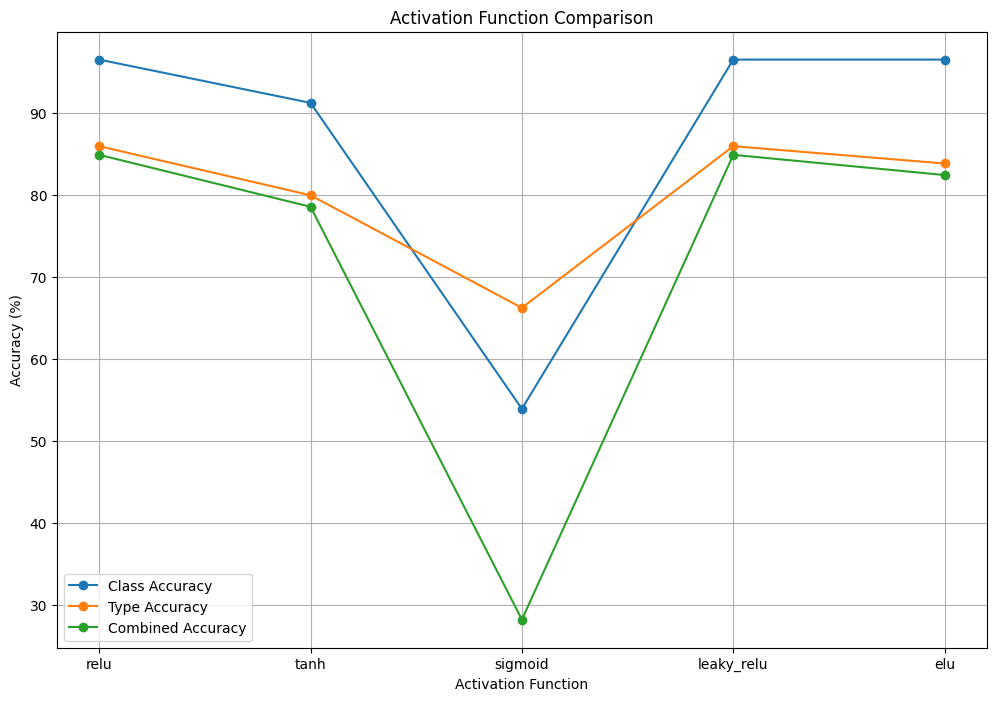

In [49]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(results_df['Activation'], results_df['Class Accuracy (%)'], label='Class Accuracy', marker='o')
plt.plot(results_df['Activation'], results_df['Type Accuracy (%)'], label='Type Accuracy', marker='o')
plt.plot(results_df['Activation'], results_df['Combined Accuracy (%)'], label='Combined Accuracy', marker='o')
plt.title('Activation Function Comparison')
plt.xlabel('Activation Function')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

As can be seen the initial function, ReLU is equivalent in ability to Leaky RelU. ELU is slightly worse but TanH and Sigmoid. Sigmoid, which is used in binary classification, would struggle with a dataset of more than two classes in each classification. Tanh isn't significantly worse but outputs values in negatives, which could skew data away from true values whilst ReLU does not allow negatives.